# Search algorithms -  visualization
The main purpose of this code is just to DEMONSTRATE different search algorithms (we do not care about efficiency; for simplicity, each node correspond to different state; ...)


In [1]:
# SUI - FIT VUT, 2020
# https://www.fit.vut.cz/study/course/14164/
# Author: Martin Sustek

#!pip install GraphvizAnim

In [2]:
from gvanim import Animation, render, gif
from gvanim.jupyter import interactive
import math
import numpy as np
from email.utils import quote
from queue import PriorityQueue

# IGNORE this part - hack - just to fill the nodes with color for better visualization and correct order of nodes
def get_ga(final_nodes):
    ga = Animation()
    def ga_graphs( self ):
        steps = self.steps()
        V, E = set(), set()
        for step in steps:
            V |= step.V
            E |= step.E
        graphs = []
        for n, s in enumerate( steps ):
            graph = [ 'digraph G {' ]
            for v in sorted(V): graph.append( '"{}" {};'.format( quote( str( v ) ), s.node_format( v ).replace("color", ("penwidth=3,color=green," if str(v) in final_nodes else "") + "style=filled,fillcolor")  ) )
            for e in E: graph.append( '"{}" -> "{}" {};'.format( quote( str( e[ 0 ] ) ), quote( str( e[ 1 ] ) ), s.edge_format( e ) ) )
            graph.append( '}' )
            graphs.append( '\n'.join( graph ) )
        return graphs
    
    ga.graphs = ga_graphs.__get__(ga, Animation)
    return ga
# end of IGNORE

In [3]:
# Node to string (0 -> "A")
def n2s(node): 
    #return node
    if node <= 25:
        return chr(node+65)
    quot, rem = divmod(node, 26)
    return n2s(quot-1) + n2s(rem)

# Number of nodes given branching factor (bf) and depth of the tree
def get_node_c(bf, depth):
    return int((math.pow(bf, depth+1)-1) / (bf - 1))

# Builds graph representing search tree
def build_tree(ga, node, bf, remain_depth = 3, costs = lambda x : 1):
    if remain_depth <= 0:
        return 
    for i in range(bf):
        child_node = node*bf + i+1
        if costs is None:
            ga.add_edge(n2s(node), n2s(child_node))
        else:
            ga.label_edge(n2s(node), n2s(child_node), costs(n2s(child_node)))
        build_tree(ga, child_node, bf, remain_depth-1, costs)

        
# Coloring functions for graph
def color_current(ga, current):
    ga.highlight_node(current, "blue")
    
def color_current_edge(ga, current, parent):
    ga.highlight_edge(parent, current, "blue")
    
def color_frontier(ga, frontier): # Open
    for n in frontier:
        ga.highlight_node(n, "orange")
        
def color_adding_frontier(ga, new, parents):
    for n in new:
        ga.highlight_edge(parents[n], n, "orange")
    
def color_final(ga, final):
    for n in final:
        ga.highlight_node(n, "green")

def color_visited(ga, visited):
    for n in visited:
        ga.highlight_node(n, "red")
        
def color_graph(ga, current, frontier, visited, final_nodes):
    ga.next_step()
    color_final(ga, final_nodes)
    color_current(ga, current)
    color_frontier(ga, frontier)
    color_visited(ga, visited)

# Animation for "bfs", "dfs", "dfs_inv", "bfs_inv"
def anim_search_no_cost(ga, root, final_nodes, par, child, method = "dfs"):
    method = method.lower()
    current = root
    frontier = []
    visited = []
    color_graph(ga, current, frontier, visited, final_nodes)
    while current not in final_nodes:  # Proper way is to put root into frontier and check if frontier is empty (this way just easier to visualize)
        #color_graph(ga, current, frontier, visited, final_nodes)        
        if current in child: # if current has child
            new_to_add = child[current]
            if method.endswith("inv"):
                new_to_add = new_to_add[::-1] # inverse the order
            frontier.extend(new_to_add)            
            color_graph(ga, current, frontier, visited, final_nodes)
            color_adding_frontier(ga, new_to_add, par)
            
        visited.append(current)
        color_graph(ga, current, frontier, visited, final_nodes)        
        if not frontier: # Open is empty
            print("No solution found")
            return False
        if method.startswith("bfs"):
            current = frontier.pop(0)
        elif method.startswith("dfs"):
            current = frontier.pop()
        color_graph(ga, current, frontier, visited, final_nodes)
        color_current_edge(ga, current,par[current])
        
    color_graph(ga, current, frontier, visited, final_nodes)
    sol = [current]    
    # if we have real problem, this is not possible, we need to store parents in our data structure, sufficient for demonstration
    while current != root: 
        current = par[current]
        sol.append(current)
    return sol[::-1]
    
# Animations for UCS + theoretically any bestFirstSearch provided heuristic (not tested)
def anim_search_cost(ga, root, final_nodes, par, child, costs, heuristic = lambda x : 0): # BestFirstSearch
    current = root
    current_cost = costs(root)
    frontier = PriorityQueue()
    frontier_items = []
    visited = []
    color_graph(ga, current, frontier_items, visited, final_nodes)
    ga.label_node(root,f"{current}:{current_cost}")
    while current not in final_nodes:  # Proper way is to put root into frontier and check if frontier is empty (this way just easier to visualize)
        #color_graph(ga, current, frontier, visited, final_nodes)        
        if current in child: # if current has child
            new_to_add = child[current]            
            for n in new_to_add:
                c = current_cost + costs(n) + heuristic(n)-heuristic(current) 
                frontier.put((c, n))
                ga.label_node(n,f"{n}:{c}")
            frontier_items = [n[1] for n in frontier.queue]
            color_graph(ga, current, frontier_items, visited, final_nodes)
            color_adding_frontier(ga, new_to_add, par)
            
        visited.append(current)
        color_graph(ga, current, frontier_items, visited, final_nodes)        
        if frontier.empty():
            print("No solution found")
            return False
        current_cost, current = frontier.get()
        frontier_items = [n[1] for n in frontier.queue]
        color_graph(ga, current, frontier_items, visited, final_nodes)
        color_current_edge(ga, current,par[current])
        
    color_graph(ga, current, frontier_items, visited, final_nodes)
    sol = [current]    
    # if we have real problem, this is not possible, we need to store parents in our data structure, sufficient for demonstration
    while current != root: 
        current = par[current]
        sol.append(current)
    return sol[::-1]

def visualize_and_save_no_cost(method_name, final_nodes, par, child, save = True, ga = None, save_name=None):
    if save_name is None:
        save_name = method_name
    if ga is None:
        ga = get_ga(final_nodes)
        build_tree(ga, 0, BF, DEPTH, None)    
    result = anim_search_no_cost(ga, n2s(0), final_nodes, par, child, method_name)
    if save:
        gif(render( ga.graphs(), save_name, 'png', 2000), save_name, 50, 2000)
    return ga, result

def visualize_and_save_cost(heuristic, final_nodes, par, child, costs, save = True, save_name="ucs"):
    ga = get_ga(final_nodes)
    build_tree(ga, 0, BF, DEPTH, costs)    
    result = anim_search_cost(ga, n2s(0), final_nodes, par, child, costs, heuristic)
    if save:
        gif(render( ga.graphs(), save_name, 'png', 2000), save_name, 50, 2000)
    return ga, result


In [4]:
BF = 2 # branching factor - integer bigger than 1
DEPTH = 3 # 

number_of_nodes = get_node_c(BF, DEPTH)
print(f"Number of nodes: {number_of_nodes}")
child_num = dict((k, [k*BF + i for i in range(1,1 + BF)]) for k in range(get_node_c(BF, DEPTH-1)))
child_str = dict((n2s(k),[n2s(v) for v in l]) for k,l in child_num.items())
par_num = dict((v,k) for k,l in child_num.items() for v in l)
par_str = dict((v,k) for k,l in child_str.items() for v in l)
#par_str = 
#print(child_num) # NODE -> list of children (numbers)
#print(child_str) # NODE -> list of children (strings)

# Final state and random costs 
final_nodes_num = np.random.randint(0, number_of_nodes, 1)
final_nodes_str = [n2s(n) for n in final_nodes_num]
print(f"Final nodes: {final_nodes_str}")
costs = np.random.randint(1, 10, number_of_nodes) # costs in range 1 - 10
costs[0] = 0 #root node has no cost
costs = dict((n2s(i),c) for i,c in enumerate(costs))
SAVE = False

Number of nodes: 15
Final nodes: ['I']


## BFS

In [5]:
METHOD = "bfs"
#final_nodes_str = []
ga, result = visualize_and_save_no_cost(METHOD, final_nodes_str, par_str, child_str, SAVE)
interactive(ga, 4000)

interactive(children=(IntSlider(value=0, description='n', max=25), Output()), _dom_classes=('widget-interact',…

## DFS

In [6]:
METHOD = "dfs"
ga, result = visualize_and_save_no_cost(METHOD, final_nodes_str, par_str, child_str, SAVE)
interactive(ga, 4000)

interactive(children=(IntSlider(value=0, description='n', max=35), Output()), _dom_classes=('widget-interact',…

## DFS - inverse order (from left)

In [7]:
METHOD = "dfs_inv"
ga, result = visualize_and_save_no_cost(METHOD, final_nodes_str, par_str, child_str, SAVE)
interactive(ga, 4000)

interactive(children=(IntSlider(value=0, description='n', max=13), Output()), _dom_classes=('widget-interact',…

## BFS - inverse order (from right to left)

In [8]:
METHOD = "bfs_inv"
#final_nodes_str = []
ga, result = visualize_and_save_no_cost(METHOD, final_nodes_str, par_str, child_str, SAVE)
interactive(ga, 4000)

interactive(children=(IntSlider(value=0, description='n', max=35), Output()), _dom_classes=('widget-interact',…

## DLS - DFS with limited depth search

In [9]:
METHOD = "dfs"
LIMIT_D = 0
#We will enforce DLS by adding a restriction that nodes at some level do not have any children
dls_child_str = dict((n2s(k), [n2s(k*BF + i) for i in range(1,1 + BF)]) for k in range(get_node_c(BF, LIMIT_D-1)))
ga, result = visualize_and_save_no_cost(METHOD, final_nodes_str, par_str, dls_child_str, SAVE, save_name = "dls")
interactive(ga, 4000)

No solution found


interactive(children=(IntSlider(value=0, description='n', max=2), Output()), _dom_classes=('widget-interact',)…

## IDS also known as DFS-ID

In [10]:
#METHOD = "dfs"
METHOD = "dfs_id"
# we use DLS where we iteratively increase the depth

#We will enforce DLS by adding a restriction that nodes at some level do not have any children
current_limit_d = 0
dls_child_str = dict((n2s(k), [n2s(k*BF + i) for i in range(1,1 + BF)]) for k in range(get_node_c(BF, current_limit_d-1)))
print(f"SEARCHING with limit {current_limit_d}")
ga, result = visualize_and_save_no_cost(METHOD, final_nodes_str, par_str, dls_child_str, SAVE, save_name = "ids")
while not result and current_limit_d < DEPTH: # just for visualization purpose, use better check in real applications!
    current_limit_d += 1    
    dls_child_str = dict((n2s(k), [n2s(k*BF + i) for i in range(1,1 + BF)]) for k in range(get_node_c(BF, current_limit_d-1)))
    print(f"SEARCHING with limit {current_limit_d}")
    ga, result = visualize_and_save_no_cost(METHOD, final_nodes_str, par_str, dls_child_str, SAVE, ga, save_name = "ids")

interactive(ga, 4000)


SEARCHING with limit 0
No solution found
SEARCHING with limit 1
No solution found
SEARCHING with limit 2
No solution found
SEARCHING with limit 3


interactive(children=(IntSlider(value=0, description='n', max=61), Output()), _dom_classes=('widget-interact',…

## UCS

In [11]:
# UCS means that it has no heuristic function (compared to informed methods such as A*)
heuristic = lambda x : 0
ga, result = visualize_and_save_cost(heuristic, final_nodes_str, par_str, child_str, lambda x: costs[x], SAVE, save_name = "ucs")  
interactive(ga, 4000)

interactive(children=(IntSlider(value=0, description='n', max=31), Output()), _dom_classes=('widget-interact',…

## UCS - all costs = 1

In [12]:
# UCS means that it has no heuristic function
heuristic = lambda x : 0
ga, result = visualize_and_save_cost(heuristic, final_nodes_str, par_str, child_str, lambda x: 1, SAVE, save_name="ucs_costs_1")  
interactive(ga, 4000)

interactive(children=(IntSlider(value=0, description='n', max=25), Output()), _dom_classes=('widget-interact',…

## UCS - more solutions

In [13]:
SOLUTION_C = 3
# UCS means that it has no heuristic function
heuristic = lambda x : 0
final_nodes_num_ = np.random.randint(0, number_of_nodes, SOLUTION_C)
final_nodes_str_ = [n2s(n) for n in final_nodes_num_]
print(final_nodes_str_)
ga, result = visualize_and_save_cost(heuristic, final_nodes_str_, par_str, child_str, lambda x: costs[x], SAVE, save_name="ucs_more_sol")  
interactive(ga, 4000)

['E', 'D', 'O']


interactive(children=(IntSlider(value=0, description='n', max=14), Output()), _dom_classes=('widget-interact',…

# Structured perceptron 
## Definition of the transportation (tram) example

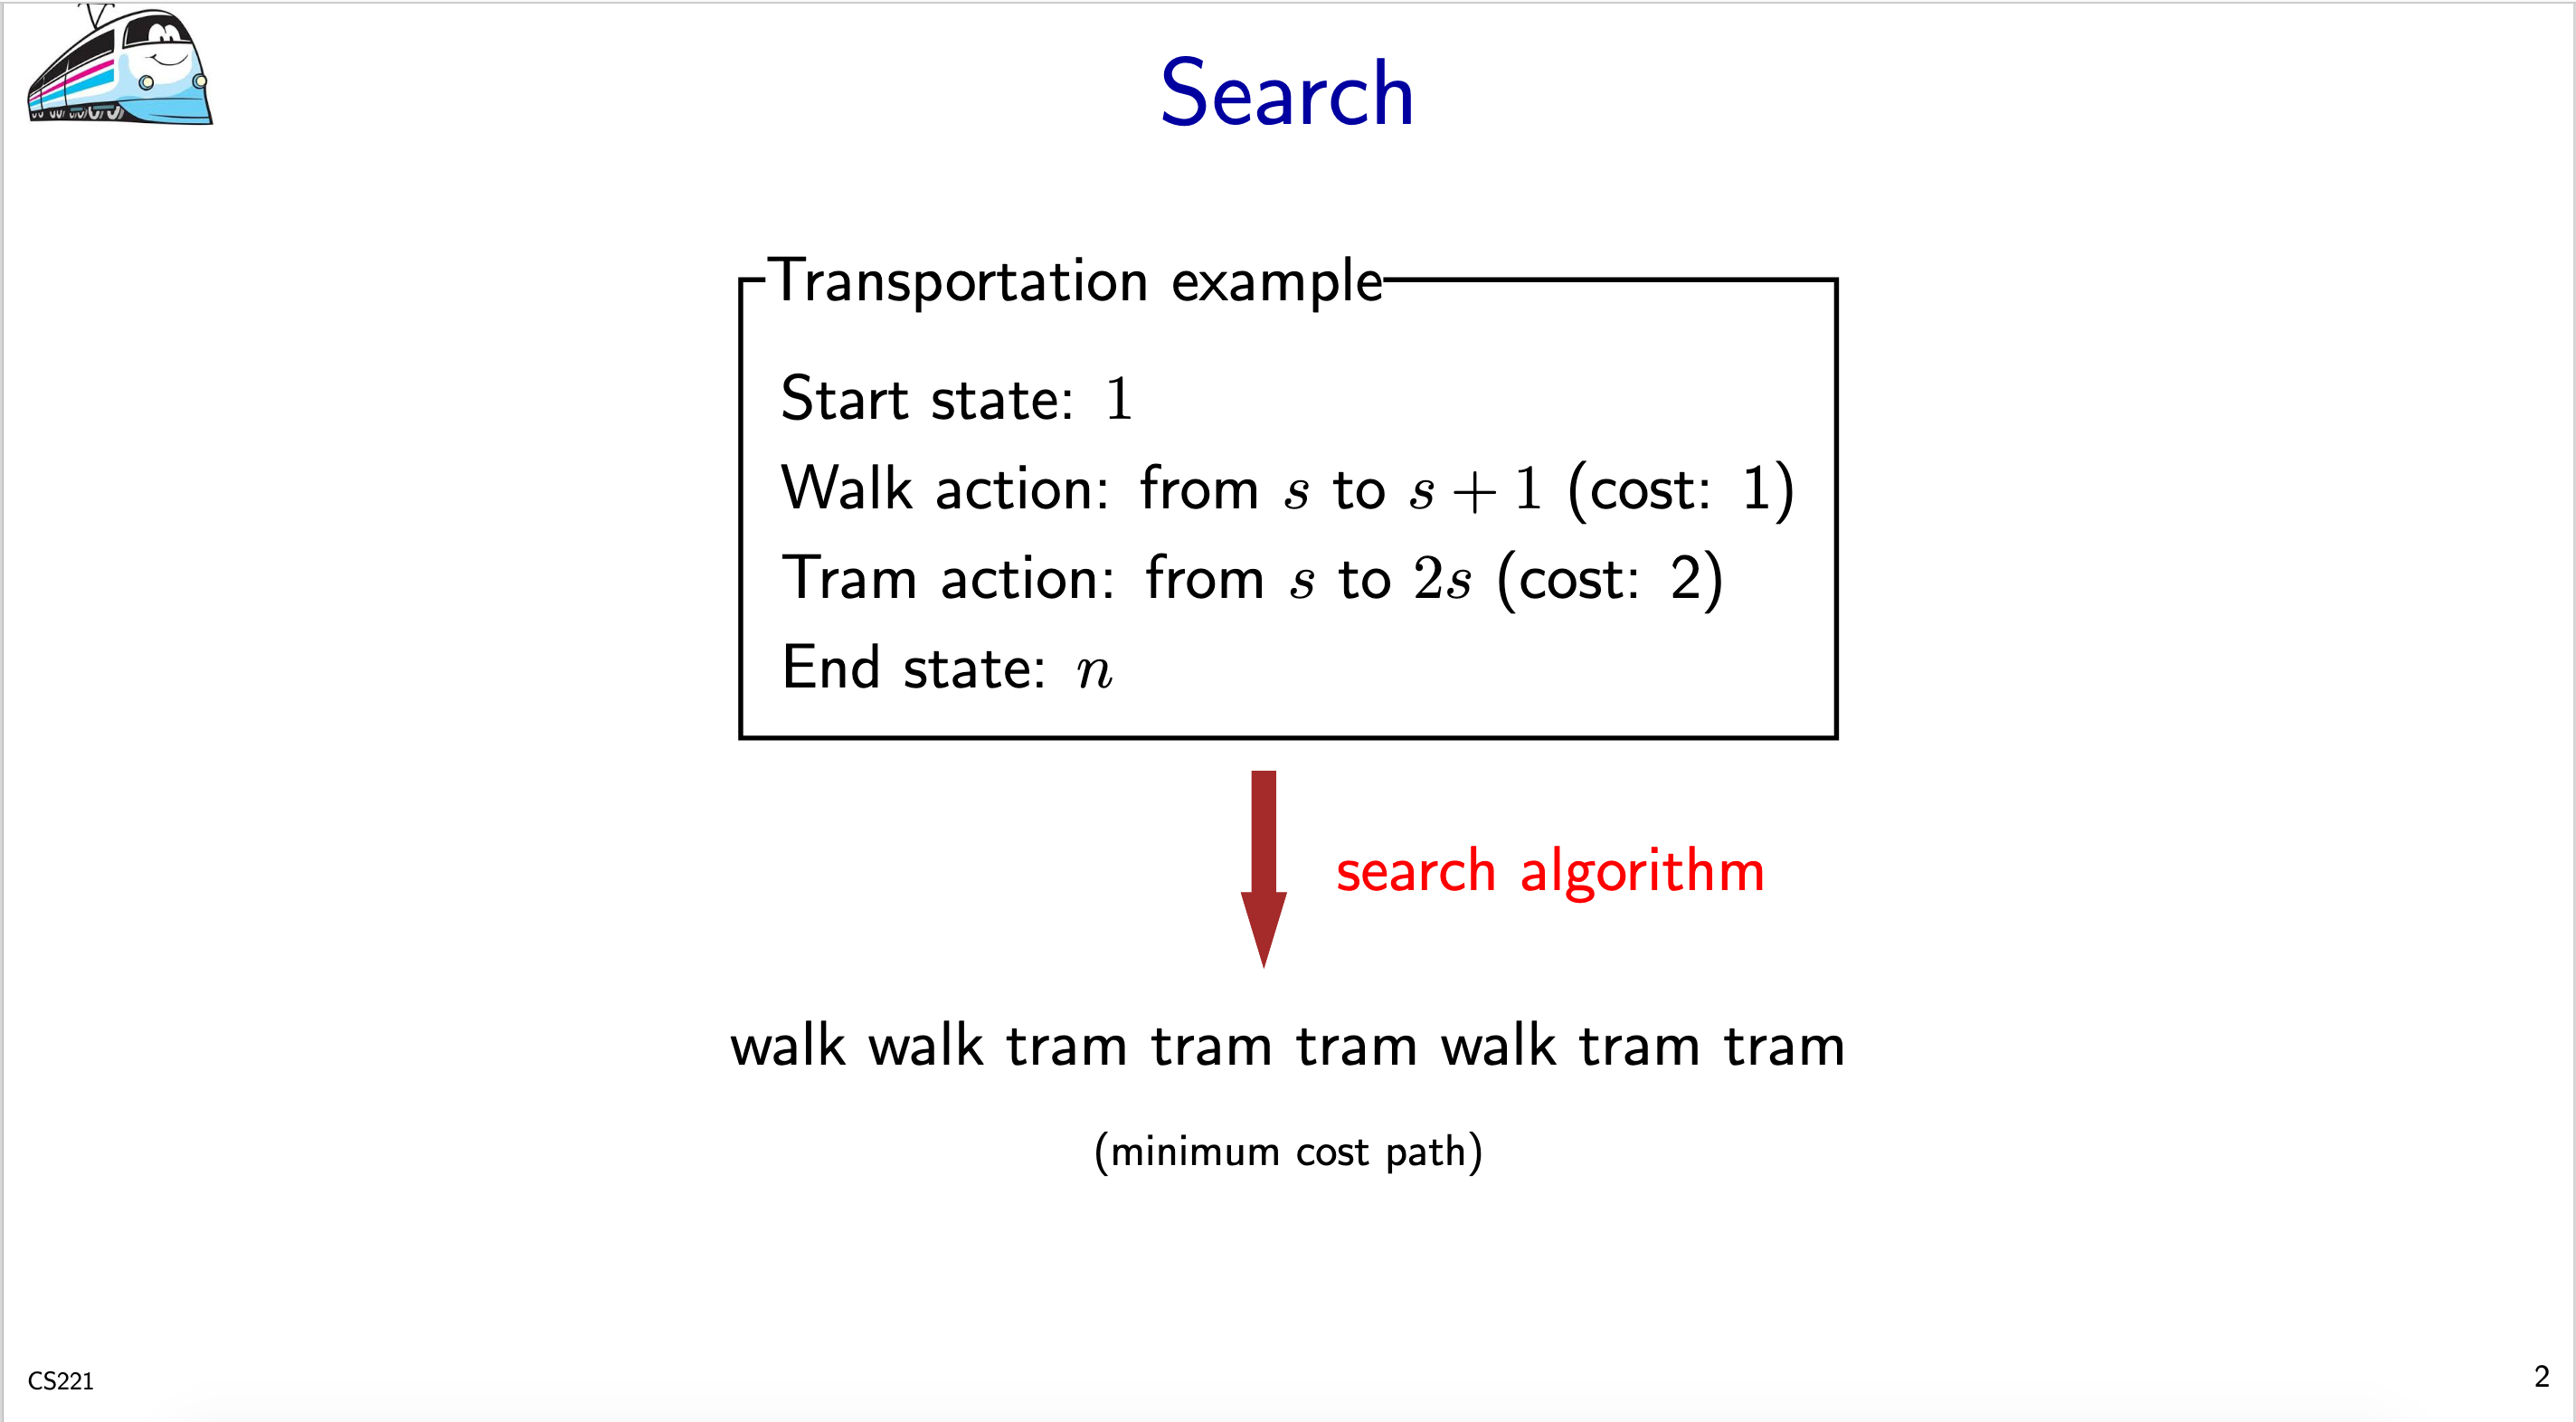
https://stanford-cs221.github.io/autumn2020-extra/modules/search/structured-perceptron.pdf

### Search tree

In [14]:
def build_tram_example_tree_costs(ga, node, label, cost, remain_depth = 3, costs = [1,2], acts = [lambda x : x + 1, lambda x : 2* x], final = 4):
    ga.label_node(node, f"{label} : {cost:.1f}")
    if label == final: # simulate final_state
        ga.highlight_node(node, "green")
    if remain_depth <= 0:
        return 
    for i in range(2):
        child_node = 2*node + i+1
        child_label = acts[i](label)
        ga.label_edge(node, child_node, str(costs[i]))
        build_tram_example_tree_costs(ga, child_node, child_label, cost + costs[i], remain_depth-1, costs, acts, final)
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity

costs = [1, 1.2]
FINALS = [1,2,3,4]
#FINALS = [1,2,3,4,8]
for depth, final in enumerate(FINALS):  
    build_tram_example_tree_costs(ga, 0, 1, 0, depth, costs = costs, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()

interactive(ga, 1000)

interactive(children=(IntSlider(value=0, description='n', max=3), Output()), _dom_classes=('widget-interact',)…

## Structured perceptron - code

In [15]:
import random
from random import sample
from queue import PriorityQueue

prec2l = lambda x:("{:5.2f} "*len(x)).format(*x)

# optimize_for_positive = if we have actions that always increase numbers, we can prune some states
def ucs_search(root, goal, actions, costs, optimize_for_increasing = True): 
    visited = 10000*[False] #For simplicity, lets just assume we have maximum state 10000
    frontier = PriorityQueue()
    frontier.put((0, (root,[]))) # for simplicity, let's store whole path
    while not frontier.empty():
        (c_cost, (c_node, c_path)) = frontier.get()
        if c_node == goal:
            return c_path
        if visited[c_node] or (optimize_for_increasing and c_node > goal): # Check if already visited 
            continue
        visited[c_node] = True
        for i in range(len(costs)):
            frontier.put((c_cost + costs[i], (actions[i](c_node), c_path + [i])))
    return False

In [16]:
#costs_star = [1,2]
costs_star = [random.uniform(0.5, 1.5),random.uniform(1.0, 6.0)]
MAX_ITERS = 30 # Maximum number of training iterations
TRAIN_D_SIZE = 5 # Number of training data
DATA_MIN, DATA_MAX = 2, 100
X = sample(range(DATA_MIN, DATA_MAX),TRAIN_D_SIZE) # 2 - 100 range of potential training data
#X = [12, 5, 13, 32]


#Let's assume we have only 2 possible actions for simplicity - actions can be performed in any state
ACTIONS = [lambda x : x + 1, lambda x : 2* x]
ROOT = 1
STEP = 1 # how much we update costs in every step - learning rate


# let's assume we have some hidden (unknown) costs costs_star and generate new data "labels" according to these costs
Y = []
for x in X:
    Y.append(ucs_search(ROOT, x, ACTIONS, costs_star))
    
print(f"Using {TRAIN_D_SIZE} samples, genereted by costs: {prec2l(costs_star)}")
print(f"Train. data: {X}")
print(f"Labels for train. data: {Y}")


# default costs
costs = [30,40]

#### Training ####
print(f"Training for maximum {MAX_ITERS} iterations:")
print(f"\tInitial costs (wei): {prec2l(costs)}")
for t in range(MAX_ITERS):
    errors = 0
    for x,y in zip(X,Y):
        y_s = ucs_search(ROOT, x, ACTIONS, costs)        
        if y != y_s:
            errors += 1
            for a in y_s:
                costs[a] += STEP
            for a in y:
                costs[a] -= STEP
    print(f"\tIteration {t:2}, costs: {prec2l(costs)}, errors: {errors}, acc: {100 - (100*errors / len(X)) :3.0f}%")
    if errors == 0:
        break
        
print(f"Final Costs: {prec2l(costs)}")
print(f"Desired costs: {prec2l(costs_star)} normalized costs {prec2l([c/costs[0]*costs_star[0] for c in costs])}")

##### "Test data" evaluation ####
errors = 0
for x in range(DATA_MIN,DATA_MAX): # Sample all possible test data between DATA_MIN and DATA_MAX
    if ucs_search(ROOT, x, ACTIONS, costs) != ucs_search(ROOT, x, ACTIONS, costs_star):
        errors += 1
print(f"Test errors: {errors}, acc: {100 - (100*errors / (DATA_MAX-DATA_MIN)) :.0f}%")

# Algorithm take advantage of everything it can! Negative weights!
# What if there are more actions?
# From atomic to structured

Using 5 samples, genereted by costs:  1.44  4.25 
Train. data: [27, 5, 97, 83, 76]
Labels for train. data: [[0, 0, 1, 1, 0, 1, 0], [0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 1, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 1, 0, 1, 1]]
Training for maximum 30 iterations:
	Initial costs (wei): 30.00 40.00 
	Iteration  0, costs: 24.00 43.00 , errors: 3, acc:  40%
	Iteration  1, costs: 22.00 44.00 , errors: 1, acc:  80%
	Iteration  2, costs: 22.00 44.00 , errors: 0, acc: 100%
Final Costs: 22.00 44.00 
Desired costs:  1.44  4.25  normalized costs  1.44  2.89 
Test errors: 0, acc: 100%


# Dynamic programming

## Definition of the city example

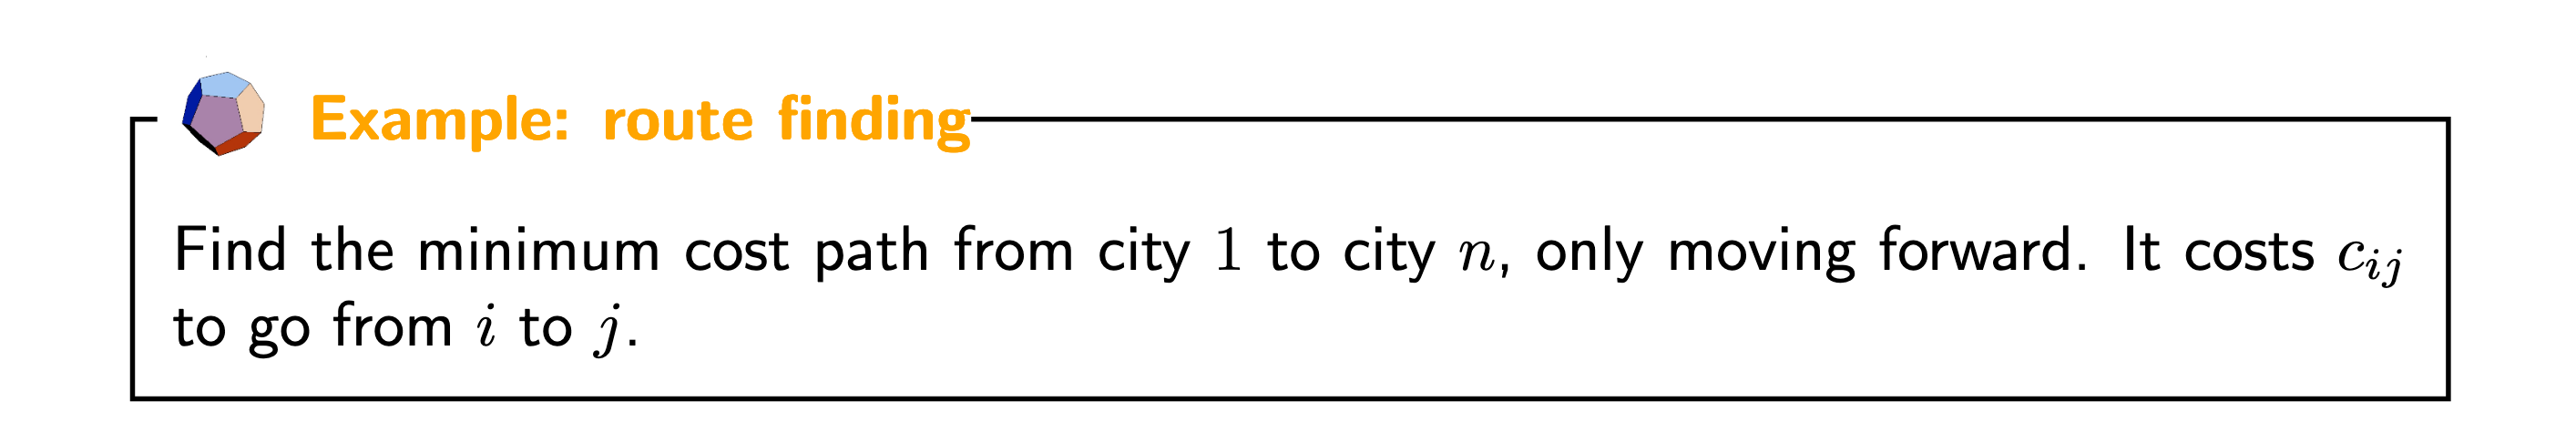
https://stanford-cs221.github.io/autumn2020-extra/modules/search/dynamic-programming.pdf

### Tree

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def build_city_example_tree(ga, node, label, final = 7, final_of_all = None):
    if final_of_all is None: # we need it to compute different node number
        final_of_all = final  
    ga.label_node(node, f"{label}")
    if label == final: # simulate final_state
        ga.highlight_node(node, "green")
        return 
    for child_label in range(label+1,final+1):
        child_node = final_of_all*node + child_label
        ga.add_edge(node, child_node)
        build_city_example_tree(ga, child_node, child_label, final, final_of_all)
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity

FIN = 7
for final in range(2,FIN + 1):
    build_city_example_tree(ga, 0, 1, final, FIN)  
    if final != FIN:
        ga.next_step()

#render(ga.graphs(), "test", 'png', 100000)#, save_name, 50, 2000)
interactive(ga, 15000)


interactive(children=(IntSlider(value=0, description='n', max=5), Output()), _dom_classes=('widget-interact',)…

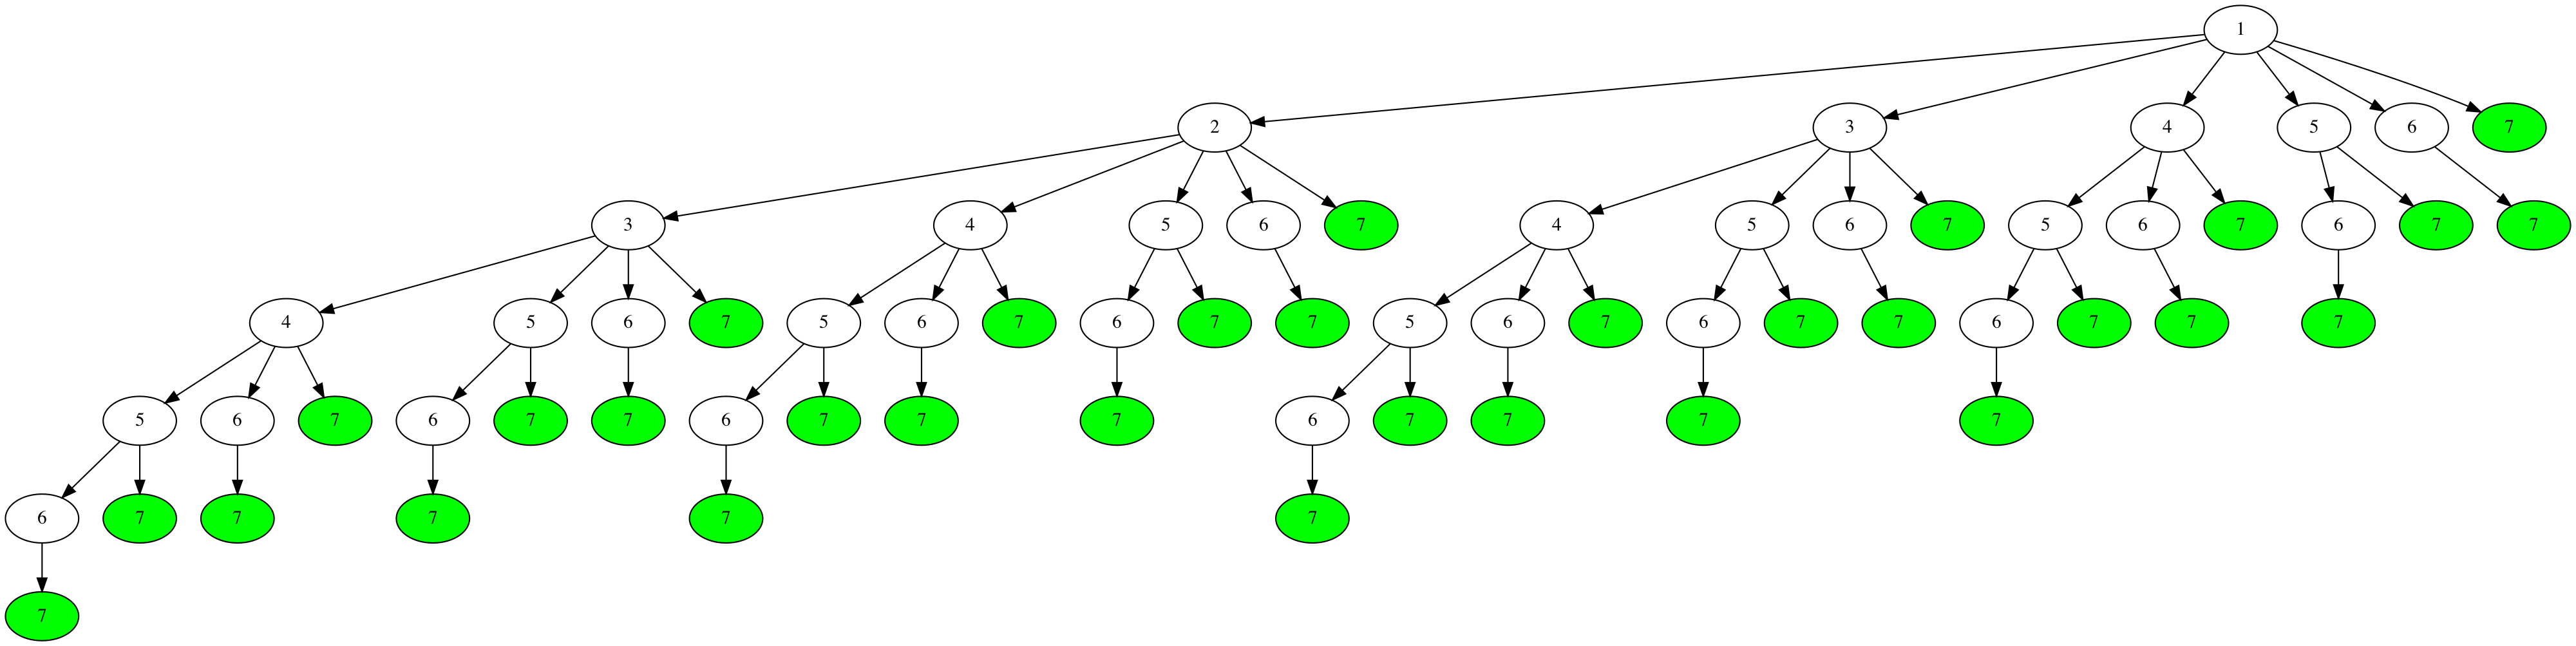

- We used the following way to evaluate any node <b>n</b>: <br>
   $\LARGE\text{A*: } \LARGE𝑓(𝑛)=𝑔(𝑛)+ℎ(𝑛)$ <br>
 - $\Large f(𝑛):$ Evaluation function (node <b>n</b>)<br> 
 - $\Large g(𝑛):$ Cost from initial node <b>n<sub>0</sub></b> to current node <b>n</b><br>
 - $\Large h(𝑛):$ Estimation of cost from <b>n</b> to closest node with end (final) state <b>n<sub>f</sub></b><br>
 <br>
- Now let's determinate minimum cost from the (initial) STATE (not node) <b><b>s<sub>0</sub></b></b> to final state <b>s<sub>f</sub></b>: <br>
   $\LARGE\text{MIN: } \LARGE minCost(s_0,s_f)= \min\limits_{a}\Big[cost(s_0,a,s)+minCost(s,s_f)\Big]$ <br>
 - $\Large cost(s,a,s'):$ Cost from node with state <b>s</b> to direct successor <b>s'</b> through the action <b>a</b><br>
 - $\Large minCost(s,s_f):$ Key observation - for nodes with the same state, this term is the same<br> 



### Graph

In [18]:
def build_tram_example_graph(ga, node, final = 7):
    #ga.label_node(node, f"{label}")
    if node == final: # simulate final_state
        #ga.highlight_node(node, "green")
        return 
    for child_node in range(node+1,final+1):
        ga.add_edge(node, child_node)
        build_tram_example_graph(ga, child_node, final)
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity

FIN = 7
for final in range(2,FIN + 1):  
    build_tram_example_graph(ga, 1, final)
    ga.highlight_node(final, "green")
    if final != FIN:
        ga.next_step()



interactive(ga, 500)

interactive(children=(IntSlider(value=0, description='n', max=5), Output()), _dom_classes=('widget-interact',)…

## Modelling
- $\LARGE\text{How is this possible?}$ <br>
 - $\Large\text{We can model the task by using a good abstraction of the state!}$ <br>
 

### City examples
$\LARGE\text{But what if it is not that straightforward?}$ <br>
 - $\Large\text{Assume that we cannot visit 3 odd cities in a row now!}$ <br>
   - $\Large\text{State cannot be represented just by current city!}$ <br>
   - $\Large\text{What about state = (current city, previous city)?}$ <br>
     - $\Large\text{Now we would potentionally have }n^2\text{states}$ <br>
   - $\Large\text{Store (current city, previous city was odd)} \rightarrow \text{Only } 2n \text{ states}$ <br>
     - $\Large\text{Is there anything better?} \rightarrow \text{Hint: } 1.5n \text{ states}?$<br>
     <br>
 - $\Large\text{Assume that we must visit at least 4 different cities + final one!}$ <br>
   - $\Large\text{Store (current city, # visited cities)?} \rightarrow n^2 \text{ states}$ <br>
   - $\Large\text{Store (current city, min(#visited cities, 4)} \rightarrow \text{Only } 4n \text{ states}$ <br>
   <br>
 - $\Large\text{Assume that we must visit more odd cities than even cities!}$ <br>
   - $\Large\text{Store (current city, #visited odd cities, #visited even cities)?}$<br> 
   - $\Large\text{No, store (current city, #visited odd cities - #visited even cities)}$<br>
<br>

### Restricted tram example:
$\Large\text{Cannot use 3 same actions in row!}$<br>
 - $\Large\text{State will be (current city, 2-history), where 2-history is one of: [_|+|*|++|**]}$

#### Original problem - TREE

In [19]:
def build_tram_example_tree_costs(ga, node, label, remain_depth = 3, acts = [lambda x : x + 1, lambda x : 2* x], acts_rep = ["+","*"], final = 8):
    ga.label_node(node, f"{label}")
    if label == final: # simulate final_state
        ga.highlight_node(node, "green")
    if remain_depth <= 0:
        return 
    for i in range(2):
        child_node = 2*node + i+1
        child_label = acts[i](label)
        ga.label_edge(node, child_node, acts_rep[i])
        build_tram_example_tree_costs(ga, child_node, child_label, remain_depth-1, acts, acts_rep, final)        
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity

FINALS = [1,2,3,4,8]
for depth, final in enumerate(FINALS):  
    build_tram_example_tree_costs(ga, 0, 1, depth, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()
interactive(ga, 1000)

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

#### Original problem - GRAPH

In [20]:
def build_tram_example_graph(ga, state, remain_depth = 3, acts = [lambda x : x + 1, lambda x : 2* x], acts_rep = ["+","*"], final = 8):
    if state == final: # simulate final_state
        ga.highlight_node(state, "green")
    if remain_depth <= 0:
        return 
    for i in range(2):
        child_state = acts[i](state)
        ga.label_edge(state, child_state, acts_rep[i])
        build_tram_example_graph(ga, child_state, remain_depth-1, acts, acts_rep, final)
        
FINALS = [1,2,3,4,8]
for depth, final in enumerate(FINALS):  
    build_tram_example_graph(ga, 1, depth, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()
        
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity

FINALS = [1,2,3,4,8]
#FINALS = [1,2,3,4,8,16]
for depth, final in enumerate(FINALS):  
    build_tram_example_graph(ga, 1, depth, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()
interactive(ga, 400)

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

#### States with full history (path) - TREE

In [21]:
import re

def extract_previous_same(full_history):
    return re.findall(r"((.)\2*$)", full_history)[0][0]

def build_tram_example_history_tree(ga, node, state, remain_depth = 3, acts = [lambda x : x + 1, lambda x : 2* x], acts_rep = ["+","*"], max_same = 3, final=final):
    state, history = state
    ga.label_node(node, f"{state}{history}")    
    if state == final: # simulate final_state
        ga.highlight_node(node, "green")
    if remain_depth <= 0:
        return 
    for i in range(2):
        new_history = extract_previous_same(history + acts_rep[i])
        if len(new_history) == max_same:
            continue
        child_node = 2*node + i+1
        child_state = acts[i](state)
        ga.label_edge(node, child_node,acts_rep[i])
        build_tram_example_history_tree(ga, child_node, (child_state, new_history), remain_depth-1, acts, acts_rep, max_same, final)
        
# Any action repetion
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity

FINALS = [1,2,3,4,8]
#FINALS = [1,2,3,4,8,16]
for depth, final in enumerate(FINALS):  
    build_tram_example_history_tree(ga, 0, (1," "), depth, max_same = 5, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()
interactive(ga, 2000)

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

#### States with full history (path) - GRAPH

In [22]:
def build_tram_example_history_graph(ga, state_f, remain_depth = 3, acts = [lambda x : x + 1, lambda x : 2* x], acts_rep = ["+","*"], max_same = 3, final=8):
    state, history = state_f
    ga.label_node(state_f, f"{state}{history}")    
    if state == final: # simulate final_state
        ga.highlight_node(state_f, "green")
    if remain_depth <= 0:
        return 
    for i in range(2):
        new_history = extract_previous_same(history + acts_rep[i])
        if len(new_history) == max_same:
            continue
        child_state = (acts[i](state),new_history)
        ga.label_edge(state_f, child_state, acts_rep[i])
        build_tram_example_history_graph(ga, child_state, remain_depth-1, acts, acts_rep, max_same, final)
        
# Any action repetion
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity

FINALS = [1,2,3,4,8]
#FINALS = [1,2,3,4,8,16]
for depth, final in enumerate(FINALS):  
    #build_tram_example_history_tree(ga, 1, depth, final=final)
    build_tram_example_history_graph(ga, (1," "), depth, max_same = 5, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()
interactive(ga, 800)

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

#### States with 2-history (path) - TREE

In [23]:
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity
# Only 2 same actions in a row
FINALS = [1,2,3,4,8]
#FINALS = [1,2,3,4,8,16]
for depth, final in enumerate(FINALS):  
    build_tram_example_history_tree(ga, 0, (1," "), depth, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()
interactive(ga, 600)

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

#### States with 2-history (path) - GRAPH

In [24]:
ga = get_ga(list(range(0,100))) # all nodes are final nodes for simplicity
FINALS = [1,2,3,4,8]
#FINALS = [1,2,3,4,8,16]
for depth, final in enumerate(FINALS):  
    #build_tram_example_history_tree(ga, 1, depth, final=final)
    build_tram_example_history_graph(ga, (1," "), depth, final=final)
    if depth != len(FINALS) - 1:
        ga.next_step()
interactive(ga, 500)

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…